# Must Run

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import geopy.distance
import seaborn as sns
import glob
import os
import scipy as sci
import scipy.signal as sig
import scipy.spatial as spa
import scipy.stats as stat
from collections import Counter
from IPython.display import Audio
import random
from matplotlib import rcParams
import math
wave = np.sin(2*np.pi*400*np.arange(10000*2)/10000)

ex = './Historical Data/%s.csv'
path = ex % 'LCM'
!wc -1 $psth

import umap
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3

# Dimension reduction and clustering libraries
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
sns.set(style = 'white', context = 'notebook', rc = {'figure.figsize':(14,10)})

grid = pd.read_csv('/Users/athenaye/Documents/GitHub/Historical-Data/PollenandBird/grid.csv', index_col=["lat","long"])
stations = pd.read_csv("/Users/athenaye/Documents/GitHub/Real-World-Data/stations.csv", index_col = 0)

def non_match_elements(a, b):
    non_match = []
    for i in a:
        if i not in b:
            non_match.append(i)
    return non_match

wc: illegal option -- 1
usage: wc [-clmw] [file ...]


In [2]:
stations

latitude  longitude                                  Station name
ACW00011604  17.11670  -61.78330                         ST JOHNS COOLIDGE FLD
ACW00011647  17.13330  -61.78330                                      ST JOHNS
AE000041196  25.33300   55.51700  SHARJAH INTER. AIRP            GSN     41196
AEM00041194  25.25500   55.36400  DUBAI INTL                             41194
AEM00041217  24.43300   54.65100  ABU DHABI INTL                         41217
...               ...        ...                                           ...
BARR         71.28241 -156.61936                                Utqiaġvik NEON
WALK         35.95738  -84.27925                            Walker Branch NEON
WLOU         39.89137 -105.91540                      West St Louis Creek NEON
WREF         45.82049 -121.95191           Wind River Experimental Forest NEON
YELL         44.95348 -110.53914                Yellowstone National Park NEON

[118573 rows x 3 columns]

In [3]:
grid

class   colors
lat    long                      
-89.75 -179.25        EF  #696969
       -178.75        EF  #696969
       -178.25        EF  #696969
       -177.75        EF  #696969
       -177.25        EF  #696969
...                  ...      ...
 83.75 -31.75         ET  #696969
       -31.25         ET  #696969
       -30.75         ET  #696969
       -30.25         ET  #696969
       -29.75         ET  #696969

[91827 rows x 2 columns]

# UMAP

## Overall Temperature

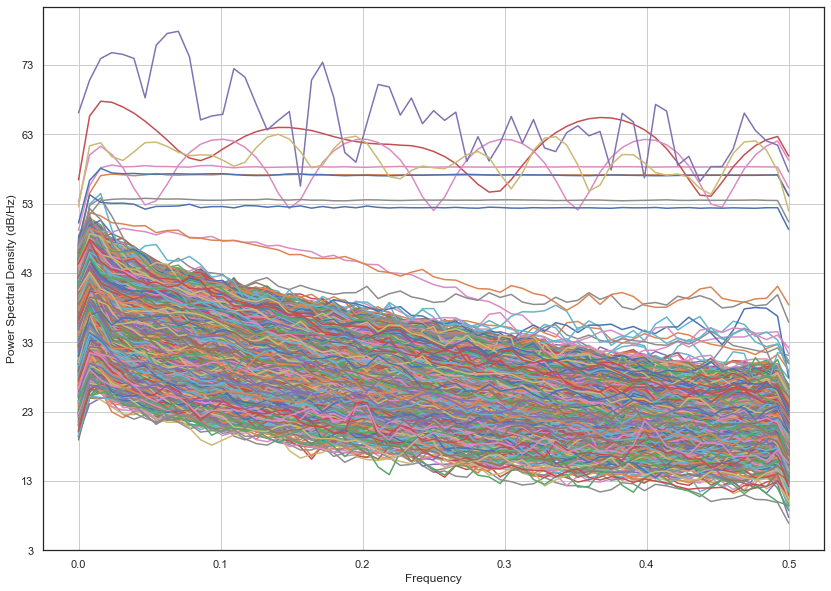

In [8]:
avgoverall = pd.read_csv('/Users/athenaye/Documents/GitHub/Historical-Data/PollenandBird/noaadata/avgoverall.csv', index_col = 'date')
avgoverall.index = pd.to_datetime(avgoverall.index)
overall = avgoverall.interpolate('time', limit_direction='both')
overall = pd.DataFrame(overall)
overall = overall.set_index(overall.index.year)
overall.columns = overall.columns.str.replace("[station ]","")
nfftstationsumapped = pd.DataFrame()
nfftstationsumappeddata = pd.DataFrame()
#data = detrendedsamp
data = overall
for s in range(len(data.columns)):
    nonan = data.iloc[:,s]
    nonan = nonan.interpolate('time', limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**7, detrend = 'linear')
    #a = stat.zscore(a)
    a = pd.DataFrame(a, index = b)
    base = sci.interpolate.interp1d(1/a.index[1:],a.iloc[1:,0], kind = 'nearest')
    xvalues = np.linspace(1,7, num = 65, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    nfftstationsumapped = pd.DataFrame(interparray, index = b, columns = [str(data.columns[s])])
    nfftstationsumappeddata = pd.concat([nfftstationsumappeddata, nfftstationsumapped], axis = 1)
colorofstation = list()
for x in range(len(overall.columns)):
    if overall.columns[x] in stations.index: 
        latoutput = ((round((stations.loc[overall.columns[x]]['latitude'] - 0.25) * 2)) / 2) + 0.25
        longoutput = ((round((stations.loc[overall.columns[x]]['longitude'] - 0.25) * 2)) / 2) + 0.25
        try:
            colorofstation.append(grid.loc[latoutput, longoutput]['colors'])
        except:
            cooList = grid.index
            coordinate = (latoutput, longoutput)
            nearest = min(cooList, key=lambda x: math.dist(x, coordinate))
            colorofstation.append(grid.loc[nearest]['colors'])
eqdist = pd.DataFrame()
eqdistind = pd.DataFrame()
for l in range(len(overall.T)):
    stationlookup = str(overall.T.index[l])
    if stationlookup in stations.index: 
        distfromeq = 0 + stations.loc[stationlookup][0]
        eqdistind = np.append(eqdistind, stationlookup)
        eqdist = np.append(eqdist, distfromeq)
        eqdist = pd.DataFrame(eqdist)
eqdist.index = eqdistind

a = nfftstationsumappeddata.T.index
b = eqdist.index

non_match = non_match_elements(a, b)
overall = overall.drop(non_match, 1)

In [9]:
um = umap.UMAP()
Y_umap1 = um.fit_transform(nfftstationsumappeddata.T.drop(non_match,0))
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap1[:, 0], Y_umap1[:, 1], color = colorofstation)
#plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (overall.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [10]:
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap1[:, 0], Y_umap1[:, 1], c = abs(eqdist[0]))
plt.colorbar(sc, label='Latitude')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (nfftstationsumappeddata.T.drop(non_match,0).index)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

## AWND

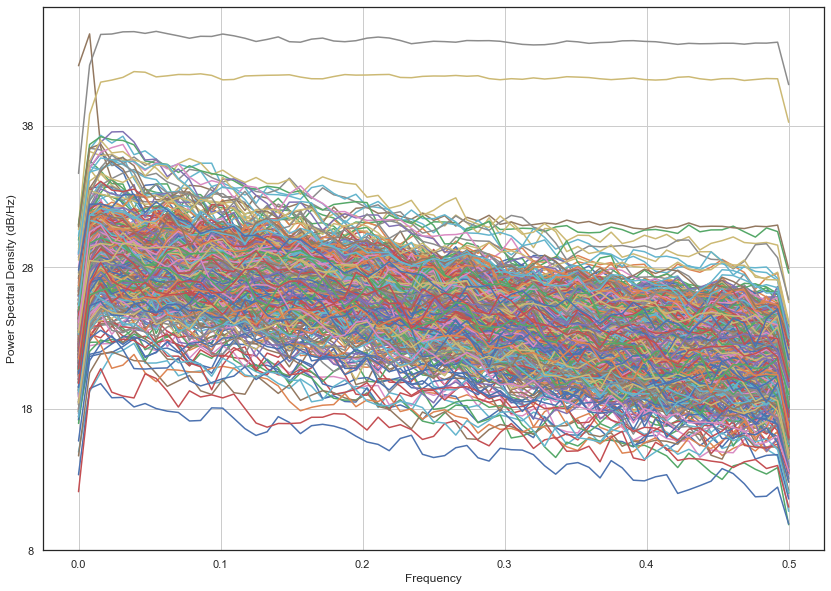

In [11]:
avgoverall = pd.read_csv('/Users/athenaye/Documents/GitHub/Historical-Data/PollenandBird/noaadata/awndoverall.csv', index_col = 0)
avgoverall.index = pd.to_datetime(avgoverall.index)
overall = avgoverall.interpolate('time', limit_direction='both')
overall = pd.DataFrame(overall)
overall = overall.set_index(overall.index.year)
overall.columns = overall.columns.str.replace("[station ]","")
nfftstationsumapped = pd.DataFrame()
nfftstationsumappeddata = pd.DataFrame()
#data = detrendedsamp
data = overall
for s in range(len(data.columns)):
    nonan = data.iloc[:,s]
    nonan = nonan.interpolate('time', limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**7, detrend = 'linear')
    #a = stat.zscore(a)
    a = pd.DataFrame(a, index = b)
    base = sci.interpolate.interp1d(1/a.index[1:],a.iloc[1:,0], kind = 'nearest')
    xvalues = np.linspace(1,7, num = 65, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    nfftstationsumapped = pd.DataFrame(interparray, index = b, columns = [str(data.columns[s])])
    nfftstationsumappeddata = pd.concat([nfftstationsumappeddata, nfftstationsumapped], axis = 1)
colorofstation = list()
for x in range(len(overall.columns)):
    if overall.columns[x] in stations.index: 
        latoutput = ((round((stations.loc[overall.columns[x]]['latitude'] - 0.25) * 2)) / 2) + 0.25
        longoutput = ((round((stations.loc[overall.columns[x]]['longitude'] - 0.25) * 2)) / 2) + 0.25
        try:
            colorofstation.append(grid.loc[latoutput, longoutput]['colors'])
        except:
            cooList = grid.index
            coordinate = (latoutput, longoutput)
            nearest = min(cooList, key=lambda x: math.dist(x, coordinate))
            colorofstation.append(grid.loc[nearest]['colors'])
eqdist = pd.DataFrame()
eqdistind = pd.DataFrame()
for l in range(len(overall.T)):
    stationlookup = str(overall.T.index[l])
    if stationlookup in stations.index: 
        distfromeq = 0 + stations.loc[stationlookup][0]
        eqdistind = np.append(eqdistind, stationlookup)
        eqdist = np.append(eqdist, distfromeq)
        eqdist = pd.DataFrame(eqdist)
eqdist.index = eqdistind
a = nfftstationsumappeddata.T.index
b = eqdist.index

non_match = non_match_elements(a, b)
overall = overall.drop(non_match, 1)

In [12]:
um = umap.UMAP()
Y_umap1 = um.fit_transform(nfftstationsumappeddata.T.drop(non_match,0))
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap1[:, 0], Y_umap1[:, 1], color = colorofstation)
#plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (overall.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [13]:
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap1[:, 0], Y_umap1[:, 1], c = abs(eqdist[0]))
plt.colorbar(sc, label='Latitude')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (nfftstationsumappeddata.T.drop(non_match,0).index)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

## Max Overall

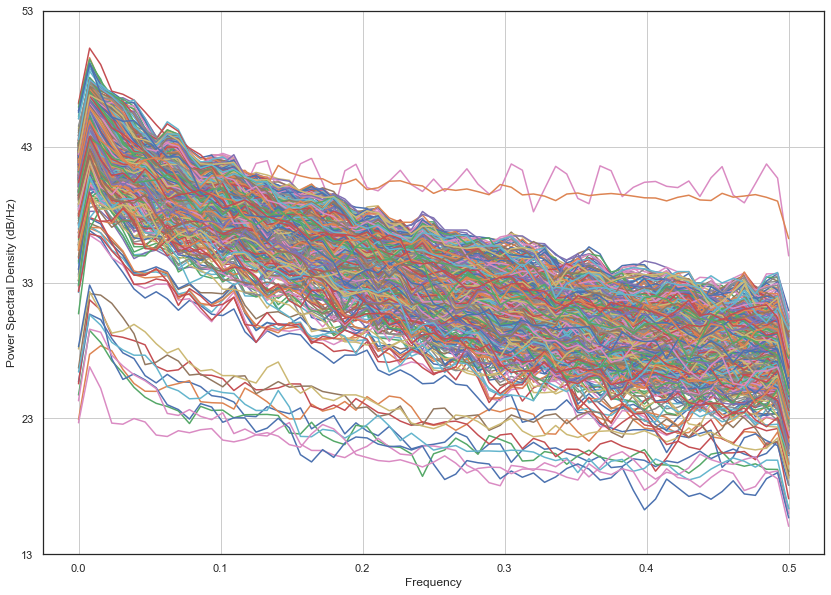

In [14]:
avgoverall = pd.read_csv('/Users/athenaye/Documents/GitHub/Historical-Data/PollenandBird/noaadata/tmaxoverall.csv', index_col = 0)
avgoverall.index = pd.to_datetime(avgoverall.index)
overall = avgoverall.interpolate('time', limit_direction='both')
overall = pd.DataFrame(overall)
overall = overall.set_index(overall.index.year)
overall.columns = overall.columns.str.replace("[station ]","")
nfftstationsumapped = pd.DataFrame()
nfftstationsumappeddata = pd.DataFrame()
#data = detrendedsamp
data = overall
for s in range(len(data.columns)):
    nonan = data.iloc[:,s]
    nonan = nonan.interpolate('time', limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**7, detrend = 'linear')
    #a = stat.zscore(a)
    a = pd.DataFrame(a, index = b)
    base = sci.interpolate.interp1d(1/a.index[1:],a.iloc[1:,0], kind = 'nearest')
    xvalues = np.linspace(1,7, num = 65, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    nfftstationsumapped = pd.DataFrame(interparray, index = b, columns = [str(data.columns[s])])
    nfftstationsumappeddata = pd.concat([nfftstationsumappeddata, nfftstationsumapped], axis = 1)
colorofstation = list()
for x in range(len(overall.columns)):
    if overall.columns[x] in stations.index: 
        latoutput = ((round((stations.loc[overall.columns[x]]['latitude'] - 0.25) * 2)) / 2) + 0.25
        longoutput = ((round((stations.loc[overall.columns[x]]['longitude'] - 0.25) * 2)) / 2) + 0.25
        try:
            colorofstation.append(grid.loc[latoutput, longoutput]['colors'])
        except:
            cooList = grid.index
            coordinate = (latoutput, longoutput)
            nearest = min(cooList, key=lambda x: math.dist(x, coordinate))
            colorofstation.append(grid.loc[nearest]['colors'])
eqdist = pd.DataFrame()
eqdistind = pd.DataFrame()
for l in range(len(overall.T)):
    stationlookup = str(overall.T.index[l])
    if stationlookup in stations.index: 
        distfromeq = 0 + stations.loc[stationlookup][0]
        eqdistind = np.append(eqdistind, stationlookup)
        eqdist = np.append(eqdist, distfromeq)
        eqdist = pd.DataFrame(eqdist)
eqdist.index = eqdistind
a = nfftstationsumappeddata.T.index
b = eqdist.index

non_match = non_match_elements(a, b)
overall = overall.drop(non_match, 1)

In [15]:
um = umap.UMAP()
Y_umap1 = um.fit_transform(nfftstationsumappeddata.T.drop(non_match,0))
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap1[:, 0], Y_umap1[:, 1], color = colorofstation)
#plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (overall.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [16]:
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap1[:, 0], Y_umap1[:, 1], c = abs(eqdist[0]))
plt.colorbar(sc, label='Latitude')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (nfftstationsumappeddata.T.drop(non_match,0).index)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

# PRCP

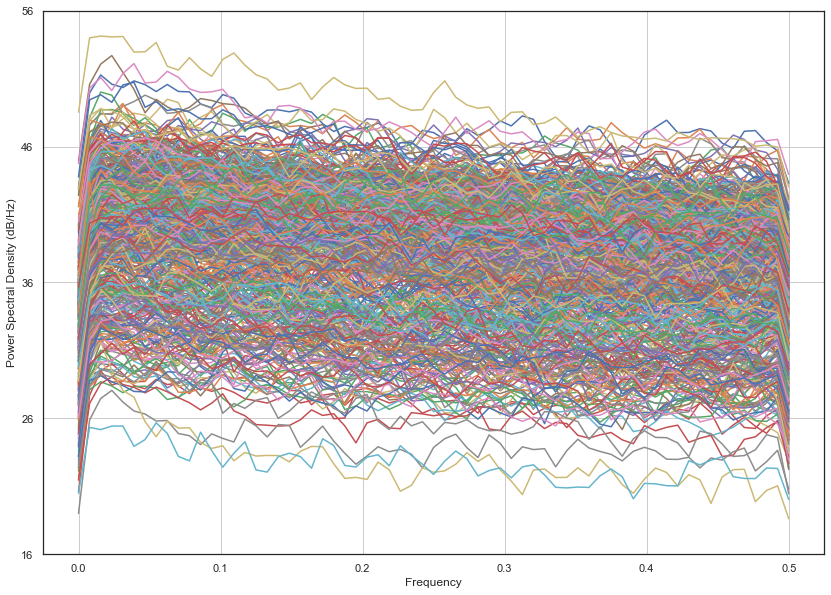

In [119]:
avgoverall = pd.read_csv('/Users/athenaye/Documents/GitHub/Historical-Data/PollenandBird/noaadata/prcpoverall.csv', index_col = 0)
avgoverall.index = pd.to_datetime(avgoverall.index)
overall = avgoverall.interpolate('time', limit_direction='both')
overall = pd.DataFrame(overall)
overall = overall.set_index(overall.index.year)
overall.columns = overall.columns.str.replace("[station ]","")
nfftstationsumapped = pd.DataFrame()
nfftstationsumappeddata = pd.DataFrame()
#data = detrendedsamp
data = overall
for s in range(len(data.columns)):
    nonan = data.iloc[:,s]
    nonan = nonan.interpolate('time', limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**7, detrend = 'linear')
    #a = stat.zscore(a)
    a = pd.DataFrame(a, index = b)
    base = sci.interpolate.interp1d(1/a.index[1:],a.iloc[1:,0], kind = 'nearest')
    xvalues = np.linspace(1,7, num = 65, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    nfftstationsumapped = pd.DataFrame(interparray, index = b, columns = [str(data.columns[s])])
    nfftstationsumappeddata = pd.concat([nfftstationsumappeddata, nfftstationsumapped], axis = 1)
colorofstation = list()
for x in range(len(overall.columns)):
    if overall.columns[x] in stations.index: 
        latoutput = ((round((stations.loc[overall.columns[x]]['latitude'] - 0.25) * 2)) / 2) + 0.25
        longoutput = ((round((stations.loc[overall.columns[x]]['longitude'] - 0.25) * 2)) / 2) + 0.25
        try:
            colorofstation.append(grid.loc[latoutput, longoutput]['colors'])
        except:
            cooList = grid.index
            coordinate = (latoutput, longoutput)
            nearest = min(cooList, key=lambda x: math.dist(x, coordinate))
            colorofstation.append(grid.loc[nearest]['colors'])
eqdist = pd.DataFrame()
eqdistind = pd.DataFrame()
for l in range(len(overall.T)):
    stationlookup = str(overall.T.index[l])
    if stationlookup in stations.index: 
        distfromeq = 0 + stations.loc[stationlookup][0]
        eqdistind = np.append(eqdistind, stationlookup)
        eqdist = np.append(eqdist, distfromeq)
        eqdist = pd.DataFrame(eqdist)
eqdist.index = eqdistind
a = nfftstationsumappeddata.T.index
b = eqdist.index

non_match = non_match_elements(a, b)
overall = overall.drop(non_match, 1)

In [120]:
um = umap.UMAP()
Y_umap1 = um.fit_transform(nfftstationsumappeddata.T.drop(non_match,0))
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap1[:, 0], Y_umap1[:, 1], color = colorofstation)
#plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (overall.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [121]:
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap1[:, 0], Y_umap1[:, 1], c = abs(eqdist[0]))
plt.colorbar(sc, label='Latitude')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (nfftstationsumappeddata.T.drop(non_match,0).index)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [20]:
def toumap(filepath, variableindicator, officialname, nfft):
    aphmeanumapped = pd.DataFrame()
    for t in range(len(filepath)):
        try:
            pHdata = pd.read_csv(filepath[t], index_col = 2)
            pHdata.index = pd.to_datetime(pHdata.index)
            pHdata = pHdata.drop('Unnamed: 0', axis = 1)
            pHdata
            pHdata = pHdata[pHdata['variable'] == variableindicator[t]]
            pHdata = pHdata.pivot(columns='siteID')[['value']]
            for x in range(len(pHdata.columns)):
                nonan = pHdata[pHdata.columns[x]]
                nonan = nonan.interpolate('time', limit_direction='both')
                a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**nfft, detrend = 'linear')
                if x == 0:
                    acumulative = a
                    bcumulative = b
                else:
                    acumulative = np.vstack([acumulative, a])
                    bcumulative = np.vstack([bcumulative, b])
            aphmean = acumulative.mean(axis=(0))
            bphmean = bcumulative.mean(axis=(0))
            aphmean = pd.DataFrame(aphmean, index = bphmean)
            base = sci.interpolate.interp1d(1/aphmean.index[1:],aphmean.iloc[1:,0], kind = 'nearest')
            xvalues = np.linspace(1,nfft-1, num = 2**(nfft-1)+1, endpoint = True)
            xvalues = xvalues[::-1]
            xvalues = 2**xvalues
            interparray = base(xvalues)
            aphmean = pd.DataFrame(interparray, index = bphmean, columns = [officialname[t]])
            aphmean = aphmean/aphmean.max()
            aphmeanumapped = pd.concat([aphmeanumapped, aphmean], axis = 1)
        except:
            avgoverall = pd.read_csv(filepath[t], index_col = 0)
            avgoverall.index = pd.to_datetime(avgoverall.index)
            avgoverallsamp = avgoverall.iloc[:,0:50]
            for x in range(len(avgoverallsamp.columns)):
                nonan = avgoverallsamp[avgoverallsamp.columns[x]]
                nonan = nonan.interpolate('linear', limit_direction = 'both')
                a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**nfft, detrend = 'linear')
                if x == 0:
                    ameancumulative = a
                    bmeancumulative = b
                else:
                    ameancumulative = np.vstack([ameancumulative, a])
                    bmeancumulative = np.vstack([bmeancumulative, b])
            amean = ameancumulative.mean(axis=(0))
            bmean = bmeancumulative.mean(axis=(0))
            amean = pd.DataFrame(amean, index = bmean)
            base = sci.interpolate.interp1d(1/amean.index[1:],amean.iloc[1:,0], kind = 'nearest')
            xvalues = np.linspace(1,nfft-1, num = 2**(nfft-1)+1, endpoint = True)
            xvalues = xvalues[::-1]
            xvalues = 2**xvalues
            interparray = base(xvalues)
            a14mean = pd.DataFrame(interparray, index = bmean, columns = [officialname[t]])
            a14mean = a14mean/a14mean.max()
            aphmeanumapped = pd.concat([aphmeanumapped, aphmean], axis = 1)
    aphmeanumapped.to_csv('/Users/athenaye/Desktop/umap.csv')

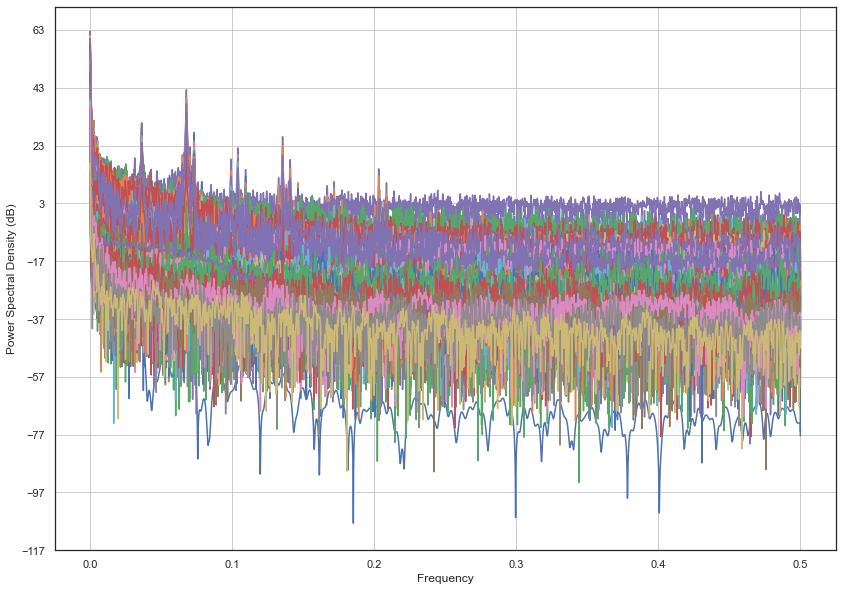

In [21]:
toumap(['/Users/athenaye/Desktop/complete/tidaldata.csv',
    '/Users/athenaye/Desktop/complete/PARMean.csv'],
          [ 'sea_level','PARMean'],
            ['tidal','Mean of Photosynthetically Active Radiation'],14)

In [ ]:
def toumappersite(filepath, variableindicator, nfft):  
    for x in range(len(filepath)):
        pHdata = pd.read_csv(filepath[x], index_col = 2)
        pHdata.index = pd.to_datetime(pHdata.index)
        pHdata = pHdata.drop('Unnamed: 0', axis = 1)
        pHdata = pHdata[pHdata['variable'] == variableindicator[x]]
        sites = pHdata[['siteID']].drop_duplicates()
        sites = sites['siteID'].tolist()
        pHdata = pHdata.pivot(columns='siteID')[['value']]
        aphmean = pd.DataFrame()
        for y in range(len(pHdata.columns)):
            nonan = pHdata[pHdata.columns[y]]
            nonan = nonan.interpolate('time', limit_direction='both')
            a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**14, detrend = 'linear')
            if y == 0:
                acumulative = a
                bcumulative = b
            else:
                acumulative = np.vstack([acumulative, a])
                bcumulative = np.vstack([bcumulative, b])
        bphmean = bcumulative.mean(axis=(0))
        aphmean = pd.DataFrame(acumulative.T, index = bphmean, columns = [sites] )
        print(x)
        aphmean.to_csv('/Users/athenaye/Documents/GitHub/Real-World-Data/' + str(variableindicator[x]) + '-umap.csv')

In [ ]:
toumappersite([
# '/Users/athenaye/Desktop/complete/tidaldata.csv',
#                 '/Users/athenaye/Desktop/complete/PARMean.csv',
#                 '/Users/athenaye/Desktop/complete/waterTemp.csv',
#                 '/Users/athenaye/Desktop/complete/concentrationCH4.csv',
#                 '/Users/athenaye/Desktop/complete/concentrationN2O.csv',
#                 '/Users/athenaye/Desktop/complete/dissolvedOxygen.csv',
#                 '/Users/athenaye/Desktop/complete/dissolvedOxygenSaturation.csv',
#                 '/Users/athenaye/Desktop/complete/euphoticDepth.csv',
#                 '/Users/athenaye/Desktop/complete/outuPARMaximum.csv',
#                 '/Users/athenaye/Desktop/complete/outuPARMean.csv',
#                 '/Users/athenaye/Desktop/complete/outuPARMinimum.csv',
#                 '/Users/athenaye/Desktop/complete/outuPARVariance.csv',
#                 '/Users/athenaye/Desktop/complete/PARMaximum.csv',
#                 '/Users/athenaye/Desktop/complete/PARMean.csv',
#                 '/Users/athenaye/Desktop/complete/PARMinimum.csv',
#                 '/Users/athenaye/Desktop/complete/PARStdErMean.csv',
#                 '/Users/athenaye/Desktop/complete/PARVariance.csv',
#                 '/Users/athenaye/Desktop/complete/sampleDepth.csv',
#                 '/Users/athenaye/Desktop/complete/secchiMeanDepth.csv',
#                 '/Users/athenaye/Desktop/complete/specificConductance.csv',
#                 '/Users/athenaye/Desktop/complete/uPARMaximum.csv',
#                 '/Users/athenaye/Desktop/complete/uPARMean.csv',
#                 '/Users/athenaye/Desktop/complete/uPARMinimum.csv',
#                 '/Users/athenaye/Desktop/complete/uPARVariance.csv',  
#                 '/Users/athenaye/Desktop/Complete Data/PARMean.csv',
#                '/Users/athenaye/Desktop/Complete Data/bioTempMean.csv',
#                '/Users/athenaye/Desktop/Complete Data/dewTempMean.csv',
#                '/Users/athenaye/Desktop/Complete Data/fDOM.csv',
#                '/Users/athenaye/Desktop/Complete Data/chlorophyll.csv',
#                '/Users/athenaye/Desktop/Complete Data/RHMean.csv',
#                '/Users/athenaye/Desktop/Complete Data/staPresMean.csv',
#                '/Users/athenaye/Desktop/Complete Data/inLWMean.csv',
#                '/Users/athenaye/Desktop/Complete Data/inSWMean.csv',
#                '/Users/athenaye/Desktop/Complete Data/outLWMean.csv',
#                '/Users/athenaye/Desktop/Complete Data/outSWMean.csv',
#                '/Users/athenaye/Desktop/Complete Data/seaLevelDissolvedOxygenSat.csv',
#                '/Users/athenaye/Desktop/Complete Data/specificConductance.csv',
#                '/Users/athenaye/Desktop/Complete Data/tempRHMean.csv',
#                 '/Users/athenaye/Desktop/Complete Data/turbidity.csv',
#                  '/Users/athenaye/Documents/GitHub/Historical-Data/PollenandBird/avgoverall.csv',
#                 '/Users/athenaye/Documents/GitHub/Historical-Data/PollenandBird/awndoverall.csv',
#                 '/Users/athenaye/Documents/GitHub/Historical-Data/PollenandBird/maxoverall.csv',
#                '/Users/athenaye/Documents/GitHub/Historical-Data/PollenandBird/minoverall.csv',
#                '/Users/athenaye/Documents/GitHub/Historical-Data/PollenandBird/prcpoverall.csv'],
#           [
#               'sea_level', 
#            'PARMean',
#            'waterTemp',
#             'concentrationCH4',
#             'concentrationN2O',
#             'dissolvedOxygen',
#             'dissolvedOxygenSaturation',
#             'euphoticDepth',
#             'outuPARMaximum',
#             'outuPARMean',
#             'outuPARMinimum',
#             'outuPARVariance',
#             'PARMaximum',
#             'PARMean',
#             'PARMinimum',
#             'PARStdErMean',
#             'PARVariance',
#             'sampleDepth',
#             'secchiMeanDepth',
#             'specificConductance',
#             'uPARMaximum',
#             'uPARMean',
#             'uPARMinimum',
#             'uPARVariance',
#             'PARMean',
#            'bioTempMean', 
#            'dewTempMean', 
#            'fDOM',
#            'chlorophyll',
#            'RHMean',
#            'staPresMean',
#            'inLWMean', 
#            'inSWMean', 
#            'outLWMean', 
#            'outSWMean', 
#            'seaLevelDissolvedOxygenSat', 
#            'specificConductance', 
#            'tempRHMean', 
#               'turbidity',
#            'avgoverall', 
#            'awndoverall', 
#            'maxoverall', 
#           'minoverall',
#            'prcpoverall'], 14)

In [23]:
tidal = pd.read_csv('/Users/athenaye/Documents/GitHub/Real-World-Data/UMAP/sea_level-umap.csv', index_col = 0)
par = pd.read_csv('/Users/athenaye/Documents/GitHub/Real-World-Data/UMAP/PARMean-umap.csv', index_col = 0)

In [94]:
oocolumns

['ARIK: specificConductance']

In [91]:
oneobservation.columns

Index(['ARIK', 'MART', 'WALK', 'TOOK', 'TOMB', 'TECR', 'SYCA', 'SUGG', 'REDB',
       'PRPO', 'PRLA', 'PRIN', 'POSE', 'OKSR', 'MCRA', 'MCDI', 'MAYF', 'WLOU',
       'LIRO', 'LEWI', 'LECO', 'KING', 'HOPB', 'GUIL', 'FLNT', 'CUPE', 'CRAM',
       'COMO', 'CARI', 'BLWA', 'BLUE', 'BLDE', 'BIGC', 'BARC'],
      dtype='object')

In [136]:
together = pd.DataFrame()
togetherwithlabels = pd.DataFrame()
for e in glob.glob("./UMAP/*.csv"): 
    oneobservationwithlabels = pd.read_csv(e, index_col = 0)
    oneobservation = pd.read_csv(e, index_col = 0)
    oocolumns = []
    e = str(e)
    e = e.split('UMAP/', 1)[1]
    e = e.split('-umap', 1)[0]
    oocolumns = []
    for t in range(len(oneobservationwithlabels.columns)):
        oocolumns.append(str(oneobservationwithlabels.columns[t]) + ': ' + e)
    oneobservationwithlabels.columns = oocolumns
    togetherwithlabels = pd.concat([togetherwithlabels,oneobservationwithlabels], axis = 1)
    together = pd.concat([together,oneobservation], axis = 1)

In [137]:
togetherwithlabels

ARIK: specificConductance  MART: specificConductance  \
0.000000               1.620380e+11                4032.863628   
0.000061               2.421041e+11                6045.415722   
0.000122               7.943897e+09                 219.682368   
0.000183               5.064491e+08                  20.112512   
0.000244               8.598146e+07                   4.939856   
...                             ...                        ...   
0.499756               2.047581e+03                   0.000004   
0.499817               2.047369e+03                   0.000007   
0.499878               2.046834e+03                   0.000009   
0.499939               2.046293e+03                   0.000011   
0.500000               1.023034e+03                   0.000006   

          WALK: specificConductance  TOOK: specificConductance  \
0.000000               1.180620e+08               1.602899e+02   
0.000061               1.767875e+08               2.658505e+02   
0.000122               6.253197e+06               2.282488e+01   
0.000183               6.294626e+05               6.747548e+00   
0.000244               2.252219e+05               3.721577e+00   
...                             ...                        ...   
0.499756               6.661029e-02               2.733619e-06   
0.499817               6.594143e-02               2.403415e-06   
0.499878               6.530606e-02               2.146211e-06   
0.499939               6.485284e-02               1.982943e-06   
0.500000               3.234440e-02               9.634933e-07   

          TOMB: specificConductance  TECR: specificConductance  \
0.000000               4.110450e+03                 901.456531   
0.000061               6.811188e+03                1452.654276   
0.000122               5.831986e+02                 103.917818   
0.000183               1.715722e+02                  26.152060   
0.000244               9.438933e+01                  12.809183   
...                             ...                        ...   
0.499756               9.788424e-05                   0.000010   
0.499817               6.048043e-05                   0.000010   
0.499878               2.882131e-05                   0.000011   
0.499939               7.685112e-06                   0.000011   
0.500000               1.328892e-07                   0.000006   

          SYCA: specificConductance  SUGG: specificConductance  \
0.000000               7.183957e+01               1.000000e+01   
0.000061               1.187704e+02               1.718843e+01   
0.000122               9.932171e+00               1.749684e+00   
0.000183               2.869877e+00               5.986258e-01   
0.000244               1.530882e+00               3.615687e-01   
...                             ...                        ...   
0.499756               1.179316e-06               2.392141e-07   
0.499817               9.140089e-07               1.919981e-07   
0.499878               6.108886e-07               1.552077e-07   
0.499939               3.751886e-07               1.316934e-07   
0.500000               1.433693e-07               6.179568e-08   

          REDB: specificConductance  PRPO: specificConductance  ...  \
0.000000               1.890965e+00                1124.559246  ...   
0.000061               3.137840e+00                1862.731193  ...   
0.000122               2.703806e-01                 158.612709  ...   
0.000183               8.015930e-02                  46.700953  ...   
0.000244               4.436963e-02                  25.754742  ...   
...                             ...                        ...  ...   
0.499756               2.437162e-08                   0.000019  ...   
0.499817               2.431776e-08                   0.000022  ...   
0.499878               2.423586e-08                   0.000024  ...   
0.499939               2.416694e-08                   0.000025  ...   
0.500000               1.207020e-08                   0.0

In [138]:
together

ARIK         MART          WALK          TOOK          TOMB  \
0.000000  1.620380e+11  4032.863628  1.180620e+08  1.602899e+02  4.110450e+03   
0.000061  2.421041e+11  6045.415722  1.767875e+08  2.658505e+02  6.811188e+03   
0.000122  7.943897e+09   219.682368  6.253197e+06  2.282488e+01  5.831986e+02   
0.000183  5.064491e+08    20.112512  6.294626e+05  6.747548e+00  1.715722e+02   
0.000244  8.598146e+07     4.939856  2.252219e+05  3.721577e+00  9.438933e+01   
...                ...          ...           ...           ...           ...   
0.499756  2.047581e+03     0.000004  6.661029e-02  2.733619e-06  9.788424e-05   
0.499817  2.047369e+03     0.000007  6.594143e-02  2.403415e-06  6.048043e-05   
0.499878  2.046834e+03     0.000009  6.530606e-02  2.146211e-06  2.882131e-05   
0.499939  2.046293e+03     0.000011  6.485284e-02  1.982943e-06  7.685112e-06   
0.500000  1.023034e+03     0.000006  3.234440e-02  9.634933e-07  1.328892e-07   

                 TECR          SYCA          SUGG          REDB         PRPO  \
0.000000   901.456531  7.183957e+01  1.000000e+01  1.890965e+00  1124.559246   
0.000061  1452.654276  1.187704e+02  1.718843e+01  3.137840e+00  1862.731193   
0.000122   103.917818  9.932171e+00  1.749684e+00  2.703806e-01   158.612709   
0.000183    26.152060  2.869877e+00  5.986258e-01  8.015930e-02    46.700953   
0.000244    12.809183  1.530882e+00  3.615687e-01  4.436963e-02    25.754742   
...               ...           ...           ...           ...          ...   
0.499756     0.000010  1.179316e-06  2.392141e-07  2.437162e-08     0.000019   
0.499817     0.000010  9.140089e-07  1.919981e-07  2.431776e-08     0.000022   
0.499878     0.000011  6.108886e-07  1.552077e-07  2.423586e-08     0.000024   
0.499939     0.000011  3.751886e-07  1.316934e-07  2.416694e-08     0.000025   
0.500000     0.000006  1.433693e-07  6.179568e-08  1.207020e-08     0.000013   

          ...         CLBJ         CARI         BONA          BLUE  \
0.000000  ...  2245.977860  2672.337362  3221.513441  3.163164e+03   
0.000061  ...  4109.512391  4843.266959  5921.093461  5.989075e+03   
0.000122  ...   666.542457   758.358964   981.110788  1.095498e+03   
0.000183  ...   208.876561   230.911480   310.189193  3.719145e+02   
0.000244  ...   104.066108   111.749768   156.226243  1.993915e+02   
...       ...          ...          ...          ...           ...   
0.499756  ...     0.000282     0.000187     0.000040  1.248455e-05   
0.499817  ...     0.000217     0.000146     0.000061  7.482014e-06   
0.499878  ...     0.000158     0.000111     0.000083  3.544801e-06   
0.499939  ...     0.000118     0.000088     0.000099  1.229711e-06   
0.500000  ...     0.000052     0.000040     0.000052  2.463499e-07   

                 BLDE         BLAN         BIGC          BARR         BARC  \
0.000000  2477.939110  3737.402167  2066.561037  2.945293e+03  3135.424442   
0.000061  4720.757974  6936.097962  3909.514232  5.461877e+03  5871.061875   
0.000122   877.756726  1192.311312   714.987365  9.419214e+02  1035.399653   
0.000183   301.114566   387.727516   242.599576  3.069726e+02   342.487068   
0.000244   162.335713   201.287645   130.314511  1.609179e+02   179.166286   
...               ...          ...          ...           ...          ...   
0.499756     0.000059     0.000081     0.000187  1.155291e-05     0.000054   
0.499817     0.000072     0.000062     0.000177  8.691730e-06     0.000052   
0.499878     0.000086     0.000036     0.000165  5.310668e-06     0.000051   
0.499939     0.000095     0.000014     0.000156  1.638599e-06     0.000049   
0.500000     0.000049     0.000002     0.000076  7.978347e-10     0.000024   

                  ARIK  
0.000000  2.602476e+03  
0.000061  4.866303e+03  
0.000122  8.550838e+02  
0.000183  2.819159e+02  
0.000244  1.472102e+02  
...                ...  
0.499756  3.461678e-05  
0.499817  2.110550e-05  
0.499878  1.008977e-05  
0.499939  2.905780e-06  
0.500000  2.062463e-07  

[8193

In [139]:
colorofstation = list()
eqdist = pd.DataFrame()
eqdistind = pd.DataFrame()
for x in range(len(together.columns)):
    stationlookup = str(together.columns[x])
    if together.columns[x] in stations.index: 
        distfromeq = 0 + stations.loc[stationlookup][0]
        eqdistind = np.append(eqdistind, stationlookup)
        eqdist = np.append(eqdist, distfromeq)
        eqdist = pd.DataFrame(eqdist)
        latoutput = ((round((stations.loc[together.columns[x]]['latitude'] - 0.25) * 2)) / 2) + 0.25
        longoutput = ((round((stations.loc[together.columns[x]]['longitude'] - 0.25) * 2)) / 2) + 0.25
        try:
            colorofstation.append(grid.loc[latoutput, longoutput]['colors'])
        except:
            cooList = grid.index
            coordinate = (latoutput, longoutput)
            nearest = min(cooList, key=lambda x: math.dist(x, coordinate))
            colorofstation.append(grid.loc[nearest]['colors'])
eqdist.index = eqdistind
a = together.columns
b = eqdist.index

non_match = non_match_elements(a, b)
together = together.drop(non_match, 1)

In [146]:
eqdist

0
ARIK  39.75821
MART  45.79084
WALK  35.95738
TOOK  68.63069
TOMB  31.85343
...        ...
BLAN  39.03370
BIGC  37.05972
BARR  71.28241
BARC  29.67598
ARIK  39.75821

[1206 rows x 1 columns]

ValueError: 'c' argument has 1206 elements, which is inconsistent with 'x' and 'y' with size 1443.

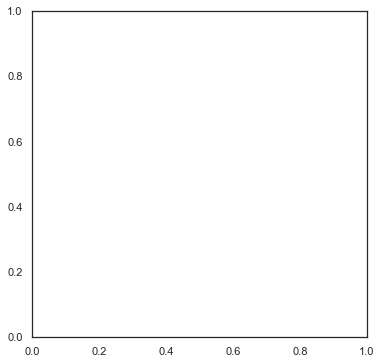

In [144]:
um = umap.UMAP()
Y_umap1 = um.fit_transform(togetherwithlabels.T)
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap1[:, 0], Y_umap1[:, 1], color = colorofstation)
#plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (togetherwithlabels.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [128]:
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap1[:, 0], Y_umap1[:, 1], c = abs(eqdist[0]))
plt.colorbar(sc, label='Latitude')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (togetherwithlabels.T.drop(non_match,0).index)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [ ]:
aphmean = pd.read_csv('/Users/athenaye/Documents/GitHub/Real-World-Data/sea_levelumap.csv')
um = umap.UMAP()
Y_umap = um.fit_transform(aphmean.T)
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c = np.array(range(0,len(aphmean.columns))))
plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (aphmean.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [ ]:
aphmean = pd.read_csv('/Users/athenaye/Documents/GitHub/Real-World-Data/PARMean-umap.csv')
um = umap.UMAP()
Y_umap = um.fit_transform(aphmean.T)
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c = np.array(range(0,len(aphmean.columns))))
plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (aphmean.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [ ]:
aphmean = pd.read_csv('/Users/athenaye/Documents/GitHub/Real-World-Data/bioTempMean-umap.csv')
um = umap.UMAP()
Y_umap = um.fit_transform(aphmean.T)
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c = np.array(range(0,len(aphmean.columns))))
plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (aphmean.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [ ]:
aphmean = pd.read_csv('/Users/athenaye/Documents/GitHub/Real-World-Data/chlorophyll-umap.csv')
um = umap.UMAP()
Y_umap = um.fit_transform(aphmean.T)
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c = np.array(range(0,len(aphmean.columns))))
plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (aphmean.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [ ]:
aphmean = pd.read_csv('/Users/athenaye/Documents/GitHub/Real-World-Data/concentrationCH4-umap.csv')
um = umap.UMAP()
Y_umap = um.fit_transform(aphmean.T)
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c = np.array(range(0,len(aphmean.columns))))
plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (aphmean.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [ ]:
aphmean = pd.read_csv('/Users/athenaye/Documents/GitHub/Real-World-Data/concentrationN2O-umap.csv')
um = umap.UMAP()
Y_umap = um.fit_transform(aphmean.T)
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c = np.array(range(0,len(aphmean.columns))))
plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (aphmean.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [ ]:
aphmean = pd.read_csv('/Users/athenaye/Documents/GitHub/Real-World-Data/dewTempMean-umap.csv')
um = umap.UMAP()
Y_umap = um.fit_transform(aphmean.T)
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c = np.array(range(0,len(aphmean.columns))))
plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (aphmean.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [ ]:
aphmean = pd.read_csv('/Users/athenaye/Documents/GitHub/Real-World-Data/dissolvedOxygen-umap.csv')
um = umap.UMAP()
Y_umap = um.fit_transform(aphmean.T)
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c = np.array(range(0,len(aphmean.columns))))
plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (aphmean.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [ ]:
file = ['dissolvedOxygenSaturation-umap.csv',
        'euphoticDepth-umap.csv',
        'fDOM-umap.csv',
        'inLWMean-umap.csv',
        'inSWMean-umap.csv',
        'outLWMean-umap.csv',
        'outSWMean-umap.csv',
        'outuPARMaximum-umap.csv',
        'outuPARMean-umap.csv',
        'outuPARMinimum-umap.csv',
        'outuPARVariance-umap.csv',
        'PARMaximum-umap.csv',
        'PARMean-umap.csv',
        'PARMinimum-umap.csv',
        'PARStdErMean-umap.csv',
        'PARVariance-umap.csv',
        'RHMean-umap.csv',
        'sampleDepth-umap.csv',
        'sea_level-umap.csv',
        'seaLevelDissolvedOxygenSat-umap.csv',
        'secchiMeanDepth-umap.csv',
        'specificConductance-umap.csv',
        'staPresMean-umap.csv',
        'tempRHMean-umap.csv',
        'turbidity-umap.csv',
        'uPARMaximum-umap.csv',
        'uPARMean-umap.csv',
        'uPARMinimum-umap.csv',
        'uPARVariance-umap.csv',
        'waterTemp-umap.csv']
for x in range(len(file)):
        aphmean = pd.read_csv('/Users/athenaye/Documents/GitHub/Real-World-Data/'+ file[x])
        um = umap.UMAP()
        Y_umap = um.fit_transform(aphmean.T)
        fig = plt.figure(figsize=(6,6))
        sc = plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c = np.array(range(0,len(aphmean.columns))))
        plt.colorbar(sc, label='Stations')
        plt.axis('equal')
        plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

        labels = ['{0}'.format(str(i)) for i in (aphmean.columns)]
        tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
        mpld3.plugins.connect(fig, tooltip)

        mpld3.display()

# Background

In [ ]:
hi = pd.read_csv('/Users/athenaye/Desktop/umap.csv', index_col = 0)
hi.T

In [ ]:
plt.plot(hi.iloc[:,1])

In [ ]:
um = umap.UMAP()
Y_umap = um.fit_transform(hi.T)
fig = plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c = np.array(range(0,len(hi.columns))))
plt.colorbar(sc, label='Stations')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

labels = ['{0}'.format(str(i)) for i in (hi.columns)]
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [ ]:
umap.utils.disconnected_vertices(hi)

In [ ]:
def toheatmap(filepath, variableindicator, officialname, nfft):
    masteramean = pd.DataFrame()
    for t in range(len(filepath)):
        try:
            pHdata = pd.read_csv(filepath[t], index_col = 2)
            pHdata.index = pd.to_datetime(pHdata.index)
            pHdata = pHdata.drop('Unnamed: 0', axis = 1)
            pHdata
            pHdata = pHdata[pHdata['variable'] == variableindicator[t]]
            pHdata = pHdata.pivot(columns='siteID')[['value']]
            for x in range(len(pHdata.columns)):
                nonan = pHdata[pHdata.columns[x]]
                nonan = nonan.interpolate('time', limit_direction='both')
                a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False, NFFT = 2**nfft, detrend = 'linear')
                if x == 0:
                    acumulative = a
                    bcumulative = b
                else:
                    acumulative = np.vstack([acumulative, a])
                    bcumulative = np.vstack([bcumulative, b])
            aphmean = acumulative.mean(axis=(0))
            bphmean = bcumulative.mean(axis=(0))
            aphmean = pd.DataFrame(aphmean, index = bphmean)
            base = sci.interpolate.interp1d(1/aphmean.index[1:],aphmean.iloc[1:,0], kind = 'nearest')
            xvalues = np.linspace(1,nfft-1, num = 2**(nfft-1)+1, endpoint = True)
            xvalues = xvalues[::-1]
            xvalues = 2**xvalues
            interparray = base(xvalues)
            aphmean = pd.DataFrame(interparray, index = 1/bphmean, columns = [officialname[t]])
            aphmean = aphmean/aphmean.max()
            masteramean = pd.concat([masteramean, aphmean], axis = 1)
        except:
            avgoverall = pd.read_csv(filepath[t], index_col = 0)
            avgoverall.index = pd.to_datetime(avgoverall.index)
            avgoverallsamp = avgoverall.iloc[:,0:50]
            for x in range(len(avgoverallsamp.columns)):
                nonan = avgoverallsamp[avgoverallsamp.columns[x]]
                nonan = nonan.interpolate('linear', limit_direction = 'both')
                a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**nfft, detrend = 'linear')
                if x == 0:
                    ameancumulative = a
                    bmeancumulative = b
                else:
                    ameancumulative = np.vstack([ameancumulative, a])
                    bmeancumulative = np.vstack([bmeancumulative, b])
            amean = ameancumulative.mean(axis=(0))
            bmean = bmeancumulative.mean(axis=(0))
            amean = pd.DataFrame(amean, index = bmean)
            base = sci.interpolate.interp1d(1/amean.index[1:],amean.iloc[1:,0], kind = 'nearest')
            xvalues = np.linspace(1,nfft-1, num = 2**(nfft-1)+1, endpoint = True)
            xvalues = xvalues[::-1]
            xvalues = 2**xvalues
            interparray = base(xvalues)
            a14mean = pd.DataFrame(interparray, index = 1/bmean, columns = [officialname[t]])
            a14mean = a14mean/a14mean.max()
            masteramean = pd.concat([masteramean, a14mean], axis = 1)
    yvalues = np.array(range(0,2**(nfft-1)+1))
    xtickmarks = [2, 4,8,16,32,64,128,256,365, 365*2, 365*4, 365*8, 365*16, 8192]

    x = xvalues
    y = yvalues
    f = sci.interpolate.interp1d(x, y)
    xtickmarks = xtickmarks[0:nfft]
    xnew = xtickmarks #Starting period, ending period, interval of jump
    ynew = f(xnew) # use interpolation function returned by `interp1d`
    rcParams['figure.figsize'] = 11.7,16.27
    s = sns.heatmap(np.log(masteramean.T), cbar_kws={'label': 'Log of Power Spectral Density'})
    s.set_title('Power Spectral Density')
    #s.set_xscale("log", base = 2)
    s.set_xlabel('Period (days)') 
    locs, labels = plt.xticks()
    newlabel = ['2d', '4d','8d','16d','32d','64d','128d','256d','1yr', '2yr', '4yr', '8yr', '16yr', '8192d']
    plt.xticks(ynew,newlabel)

In [ ]:
tidal = pd.read_csv('/Users/athenaye/Desktop/complete/tidaldata.csv')

In [ ]:
tidal

In [ ]:
toheatmap([
    '/Users/athenaye/Desktop/complete/tidaldata.csv',
    '/Users/athenaye/Desktop/complete/PARMean.csv',
    '/Users/athenaye/Desktop/complete/waterTemp.csv',
'/Users/athenaye/Desktop/complete/concentrationCH4.csv',
'/Users/athenaye/Desktop/complete/concentrationN2O.csv',
'/Users/athenaye/Desktop/complete/dissolvedOxygen.csv',
'/Users/athenaye/Desktop/complete/dissolvedOxygenSaturation.csv',
'/Users/athenaye/Desktop/complete/euphoticDepth.csv',
'/Users/athenaye/Desktop/complete/outuPARMaximum.csv',
'/Users/athenaye/Desktop/complete/outuPARMean.csv',
'/Users/athenaye/Desktop/complete/outuPARMinimum.csv',
'/Users/athenaye/Desktop/complete/outuPARVariance.csv',
'/Users/athenaye/Desktop/complete/PARMaximum.csv',
'/Users/athenaye/Desktop/complete/PARMean.csv',
'/Users/athenaye/Desktop/complete/PARMinimum.csv',
'/Users/athenaye/Desktop/complete/PARStdErMean.csv',
'/Users/athenaye/Desktop/complete/PARVariance.csv',
'/Users/athenaye/Desktop/complete/sampleDepth.csv',
'/Users/athenaye/Desktop/complete/secchiMeanDepth.csv',
'/Users/athenaye/Desktop/complete/specificConductance.csv',
'/Users/athenaye/Desktop/complete/uPARMaximum.csv',
'/Users/athenaye/Desktop/complete/uPARMean.csv',
'/Users/athenaye/Desktop/complete/uPARMinimum.csv',
'/Users/athenaye/Desktop/complete/uPARVariance.csv'],
          ['sea_level', 'PARMean','waterTemp',
'concentrationCH4',
'concentrationN2O',
'dissolvedOxygen',
'dissolvedOxygenSaturation',
'euphoticDepth',
'outuPARMaximum',
'outuPARMean',
'outuPARMinimum',
'outuPARVariance',
'PARMaximum',
'PARMean',
'PARMinimum',
'PARStdErMean',
'PARVariance',
'sampleDepth',
'secchiMeanDepth',
'specificConductance',
'uPARMaximum',
'uPARMean',
'uPARMinimum',
'uPARVariance'],
            ['Tidal Data','Mean of Photosynthetically Active Radiation','waterTemp',
'concentrationCH4',
'concentrationN2O',
'dissolvedOxygen',
'dissolvedOxygenSaturation',
'euphoticDepth',
'outuPARMaximum',
'outuPARMean',
'outuPARMinimum',
'outuPARVariance',
'PARMaximum',
'PARMean',
'PARMinimum',
'PARStdErMean',
'PARVariance',
'sampleDepth',
'secchiMeanDepth',
'specificConductance',
'uPARMaximum',
'uPARMean',
'uPARMinimum',
'uPARVariance'],14)

In [ ]:
toheatmap(['/Users/athenaye/Desktop/complete/tidaldata.csv',
    '/Users/athenaye/Desktop/complete/PARMean.csv',
    '/Users/athenaye/Desktop/complete/waterTemp.csv',
'/Users/athenaye/Desktop/complete/concentrationCH4.csv',
'/Users/athenaye/Desktop/complete/concentrationN2O.csv',
'/Users/athenaye/Desktop/complete/dissolvedOxygen.csv',
'/Users/athenaye/Desktop/complete/dissolvedOxygenSaturation.csv',
'/Users/athenaye/Desktop/complete/euphoticDepth.csv',
'/Users/athenaye/Desktop/complete/outuPARMaximum.csv',
'/Users/athenaye/Desktop/complete/outuPARMean.csv',
'/Users/athenaye/Desktop/complete/outuPARMinimum.csv',
'/Users/athenaye/Desktop/complete/outuPARVariance.csv',
'/Users/athenaye/Desktop/complete/PARMaximum.csv',
'/Users/athenaye/Desktop/complete/PARMean.csv',
'/Users/athenaye/Desktop/complete/PARMinimum.csv',
'/Users/athenaye/Desktop/complete/PARStdErMean.csv',
'/Users/athenaye/Desktop/complete/PARVariance.csv',
'/Users/athenaye/Desktop/complete/sampleDepth.csv',
'/Users/athenaye/Desktop/complete/secchiMeanDepth.csv',
'/Users/athenaye/Desktop/complete/specificConductance.csv',
'/Users/athenaye/Desktop/complete/uPARMaximum.csv',
'/Users/athenaye/Desktop/complete/uPARMean.csv',
'/Users/athenaye/Desktop/complete/uPARMinimum.csv',
'/Users/athenaye/Desktop/complete/uPARVariance.csv',  '/Users/athenaye/Desktop/Complete Data/PARMean.csv',
           '/Users/athenaye/Desktop/Complete Data/bioTempMean.csv',
           '/Users/athenaye/Desktop/Complete Data/dewTempMean.csv',
           '/Users/athenaye/Desktop/Complete Data/fDOM.csv',
           '/Users/athenaye/Desktop/Complete Data/chlorophyll.csv',
           '/Users/athenaye/Desktop/Complete Data/RHMean.csv',
           '/Users/athenaye/Desktop/Complete Data/staPresMean.csv',
           #'/Users/athenaye/Desktop/Complete Data/chlaRelativeFluorescence.csv',
           '/Users/athenaye/Desktop/Complete Data/inLWMean.csv',
           '/Users/athenaye/Desktop/Complete Data/inSWMean.csv',
           #'/Users/athenaye/Desktop/Complete Data/localDissolvedOxygenSat.csv',
           '/Users/athenaye/Desktop/Complete Data/outLWMean.csv',
           '/Users/athenaye/Desktop/Complete Data/outSWMean.csv',
           '/Users/athenaye/Desktop/Complete Data/seaLevelDissolvedOxygenSat.csv',
           '/Users/athenaye/Desktop/Complete Data/specificConductance.csv',
           '/Users/athenaye/Desktop/Complete Data/tempRHMean.csv',
            '/Users/athenaye/Desktop/Complete Data/turbidity.csv',
         '/Users/athenaye/Documents/GitHub/Historical-Data/PollenandBird/avgoverall.csv',
           '/Users/athenaye/Documents/GitHub/Historical-Data/PollenandBird/awndoverall.csv',
           '/Users/athenaye/Documents/GitHub/Historical-Data/PollenandBird/maxoverall.csv',
           '/Users/athenaye/Documents/GitHub/Historical-Data/PollenandBird/minoverall.csv',
           '/Users/athenaye/Documents/GitHub/Historical-Data/PollenandBird/prcpoverall.csv',
#             '/Users/athenaye/Desktop/complete/initialStageHeight.csv', 
#             '/Users/athenaye/Desktop/complete/endStageHeight.csv',
#             '/Users/athenaye/Desktop/complete/streamStage.csv', 
#             '/Users/athenaye/Desktop/complete/totalDischarge.csv'
],
          ['sea_level', 'PARMean','waterTemp',
'concentrationCH4',
'concentrationN2O',
'dissolvedOxygen',
'dissolvedOxygenSaturation',
'euphoticDepth',
'outuPARMaximum',
'outuPARMean',
'outuPARMinimum',
'outuPARVariance',
'PARMaximum',
'PARMean',
'PARMinimum',
'PARStdErMean',
'PARVariance',
'sampleDepth',
'secchiMeanDepth',
'specificConductance',
'uPARMaximum',
'uPARMean',
'uPARMinimum',
'uPARVariance','PARMean','bioTempMean', 'dewTempMean', 'fDOM','chlorophyll','RHMean','staPresMean',
          #'chlaRelativeFluorescence', 
           'inLWMean', 'inSWMean', 
          # 'localDissolvedOxygenSat', 
           'outLWMean', 'outSWMean', 
           'seaLevelDissolvedOxygenSat', 'specificConductance', 'tempRHMean', 
              'turbidity',
           'avgoverall', 'awndoverall', 'maxoverall', 
          'minoverall', 'prcpoverall',
#            'initialStageHeight.csv', 
#             'endStageHeight',
#             'streamStage', 
#             'totalDischarge'
          ],
            ['Tidal Data','Mean of Photosynthetically Active Radiation','waterTemp',
'concentrationCH4',
'concentrationN2O',
'dissolvedOxygen',
'dissolvedOxygenSaturation',
'euphoticDepth',
'outuPARMaximum',
'outuPARMean',
'outuPARMinimum',
'outuPARVariance',
'PARMaximum',
'PARMean',
'PARMinimum',
'PARStdErMean',
'PARVariance',
'sampleDepth',
'secchiMeanDepth',
'specificConductance',
'uPARMaximum',
'uPARMean',
'uPARMinimum',
'uPARVariance','Mean of Photosynthetically Active Radiation', 'Infrared Radiation Biological Temperature Mean', 'Dew Point Temperature', 'Fluorescent Dissolved Organic Matter Data', 'Chlorophyll Levels','Relative Humidity Mean',
             'Mean Pressure', 
             #'Fluorescence Response to Chlorophyll ', 
             'Incoming Longwave Radiation Mean', 'Incoming Shortwave Radiation Mean', 
             #'Dissolved Oxygen % Saturation at Local Conditions', 
             'Outgoing Longwave Radiation Mean', 
             'Outgoing Shortwave Radiation Mean', 'Dissolved Oxygen % Saturation Corrected to Sea Level', 'Conductivity Auto-Corrected to 25 degrees C', 'Mean of Temperature Measures by RH sensor',
              'Turbidity of Water',
           'Mean of Temperature from NOAA Stations', 'Mean of Wind Speed from NOAA Stations', 'Maximum Temperature from NOAA Stations', 
          'Maximum Temperature from NOAA Stations', 'Precipitation Measurements (cm) from NOAA Stations',
#              'initialStageHeight.csv', 
#             'endStageHeight',
#             'streamStage', 
#             'totalDischarge'
            ],14)

In [ ]:
toheatmap([
    '/Users/athenaye/Desktop/Complete Data/PARMean.csv',
           '/Users/athenaye/Desktop/Complete Data/bioTempMean.csv',
           '/Users/athenaye/Desktop/Complete Data/dewTempMean.csv',
           '/Users/athenaye/Desktop/Complete Data/fDOM.csv',
           '/Users/athenaye/Desktop/Complete Data/chlorophyll.csv',
           '/Users/athenaye/Desktop/Complete Data/RHMean.csv',
           '/Users/athenaye/Desktop/Complete Data/staPresMean.csv',
           #'/Users/athenaye/Desktop/Complete Data/chlaRelativeFluorescence.csv',
           '/Users/athenaye/Desktop/Complete Data/inLWMean.csv',
           '/Users/athenaye/Desktop/Complete Data/inSWMean.csv',
           #'/Users/athenaye/Desktop/Complete Data/localDissolvedOxygenSat.csv',
           '/Users/athenaye/Desktop/Complete Data/outLWMean.csv',
           '/Users/athenaye/Desktop/Complete Data/outSWMean.csv',
           '/Users/athenaye/Desktop/Complete Data/seaLevelDissolvedOxygenSat.csv',
           '/Users/athenaye/Desktop/Complete Data/specificConductance.csv',
           '/Users/athenaye/Desktop/Complete Data/tempRHMean.csv',
            '/Users/athenaye/Desktop/Complete Data/turbidity.csv',
           './PollenandBird/avgoverall.csv',
           './PollenandBird/awndoverall.csv',
           './PollenandBird/maxoverall.csv',
           './PollenandBird/minoverall.csv',
           './PollenandBird/prcpoverall.csv'],
          ['PARMean','bioTempMean', 'dewTempMean', 'fDOM','chlorophyll','RHMean','staPresMean',
          #'chlaRelativeFluorescence', 
           'inLWMean', 'inSWMean', 
          # 'localDissolvedOxygenSat', 
           'outLWMean', 'outSWMean', 
           'seaLevelDissolvedOxygenSat', 'specificConductance', 'tempRHMean', 
              'turbidity',
           'avgoverall', 'awndoverall', 'maxoverall', 
          'minoverall', 'prcpoverall'],
            ['Mean of Photosynthetically Active Radiation', 'Infrared Radiation Biological Temperature Mean', 'Dew Point Temperature', 'Fluorescent Dissolved Organic Matter Data', 'Chlorophyll Levels','Relative Humidity Mean',
             'Mean Pressure', 
             #'Fluorescence Response to Chlorophyll ', 
             'Incoming Longwave Radiation Mean', 'Incoming Shortwave Radiation Mean', 
             #'Dissolved Oxygen % Saturation at Local Conditions', 
             'Outgoing Longwave Radiation Mean', 
             'Outgoing Shortwave Radiation Mean', 'Dissolved Oxygen % Saturation Corrected to Sea Level', 'Conductivity Auto-Corrected to 25 degrees C', 'Mean of Temperature Measures by RH sensor',
              'Turbidity of Water',
           'Mean of Temperature from NOAA Stations', 'Mean of Wind Speed from NOAA Stations', 'Maximum Temperature from NOAA Stations', 
          'Maximum Temperature from NOAA Stations', 'Precipitation Measurements (cm) from NOAA Stations'],14)

# Lomb-Scargle

In [ ]:
simpleavgoverall = avgoverall.iloc[:,0::50].interpolate('time', limit_direction='both')

In [ ]:
lsfreq = np.linspace(0,0.5, 81930)
# lsfreq = 2**lsfreq
# lsfreq = 1/lsfreq
lombscargle = pd.DataFrame()
for s in range(len(simpleavgoverall.columns)):
    lc = sig.lombscargle(simpleavgoverall.index, simpleavgoverall.iloc[:,s], lsfreq[1:])
    lc = pd.DataFrame(lc)
    lombscargle = pd.concat([lombscargle, lc], axis = 1)
lombscargle.index = lsfreq[1:]
lombscargle.columns = simpleavgoverall.columns
lombscargle

In [ ]:
stationsumapped = pd.DataFrame()
stationsumappeddata = pd.DataFrame()
data = detrendedsamp
for s in range(len(data.columns)):
    nonan = data.iloc[:,s]
    nonan = nonan.interpolate('time', limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = True, NFFT = 2**14, detrend = 'linear')
    a = pd.DataFrame(a, index = b)
    base = sci.interpolate.interp1d(1/a.index[1:],a.iloc[1:,0], kind = 'nearest')
    xvalues = np.linspace(1,13, num = 8193, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    stationsumapped = pd.DataFrame(interparray, index = b, columns = [str(data.columns[s])])
    stationsumappeddata = pd.concat([stationsumappeddata, stationsumapped], axis = 1)

In [ ]:
y = stationsumappeddata.iloc[0:4].mean()
x = stationsumappeddata.iloc[5:8].mean()
w = stationsumappeddata.iloc[9:16].mean()
a = stationsumappeddata.iloc[17:36].mean()
b = stationsumappeddata.iloc[37:64].mean()
c = stationsumappeddata.iloc[65:128].mean()
d= stationsumappeddata.iloc[129:256].mean()
e = stationsumappeddata.iloc[257:512].mean()
f=stationsumappeddata.iloc[513:1024].mean()
g=stationsumappeddata.iloc[1024:2048].mean()
h=stationsumappeddata.iloc[2049:4096].mean()
i=stationsumappeddata.iloc[4097:8194].mean()
grouped = pd.DataFrame([y,x,w,a,b,c,d,e,f,g,h,i])
groupedindex = ['2-4 days','4-8 days','8-16 days','16-32 days','32-64 days','64-128 days','128-256 days','256-512 days','512-1024 days','1024-2048 days','2048-4196 days','4196-8392 days']
grouped.index = groupedindex[::-1]

In [ ]:
sns.heatmap(np.sin(lombscargle.T))

In [ ]:
lsinterpolated = pd.DataFrame()
for x in range(len(lombscargle.columns)):
    base = sci.interpolate.interp1d(1/lombscargle.index[1:],lombscargle.iloc[1:,x], kind = 'nearest')
    xvalues = np.linspace(2,6, num = 8193, endpoint = True)
    xvalues = xvalues[::-1]
    xvalues = 2**xvalues
    interparray = base(xvalues)
    series = pd.Series(interparray, index = xvalues)
    lsinterpolated = pd.concat([lsinterpolated, series], axis = 1)
    lsinterpolated.rename_axis('frequency')
    lsinterpolated.rename_axis('measurement', axis='columns')
lsinterpolated.columns = lombscargle.columns